# Campesan Giulia-2027592 
# NNDL 2021/2022 
## 2nd Homework
## Outline

* [Introduction](#Introduction)
    * [Dataset](#Dataset)
* [AutoEncoder](#AutoEncoder)
    * [Methods](#Methods)
    * [Results](#Results)
       * [Samples generation](#Generation)
    * [Optuna Optimization](#Optuna)
        * [Results](#Optuna-Results)
        * [PCA and t-SNE & Samples generation](#Optuna-Generation)
* [Supervised Fine Tuning](#Supervised)
    * [Methods](#Supervised-Methods)
    * [Results](#Supervised-Results)
* [Variational Auto Encoder](#VAE)
    * [Methods](#VAE-Methods)
    * [Results](#VAE-Results)
* [Conclusions](#Conclusions)


#### Importing libraries and setting loggers
        

In [1]:
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd 
import random 
import os 
from tqdm import tqdm 

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import nn
import torch.cuda

import pytorch_lightning as pl
import optparse
import torch.nn.functional as F

import optuna
from optuna.integration import PyTorchLightningPruningCallback
optuna.logging.set_verbosity(optuna.logging.WARNING)

import plotly.express as px

from pytorch_lightning import Callback
from pytorch_lightning.callbacks import ModelCheckpoint

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

import seaborn as sn


from sklearn.metrics import confusion_matrix

import logging
logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)

## Introduction <a class="anchor" id="Introduction"></a>
In this notebook I build and analyse the capabilities of Autoencoders.
An autoencoder, in general, is a network that is trained to attempt to copy its input to its output. Internally, it has a latent space that describes a code used to represent the input. The network may be viewed as consisting of two parts: an encoder function $h=f(x)$ and a decoder that produces a reconstruction $r=g(h)$.

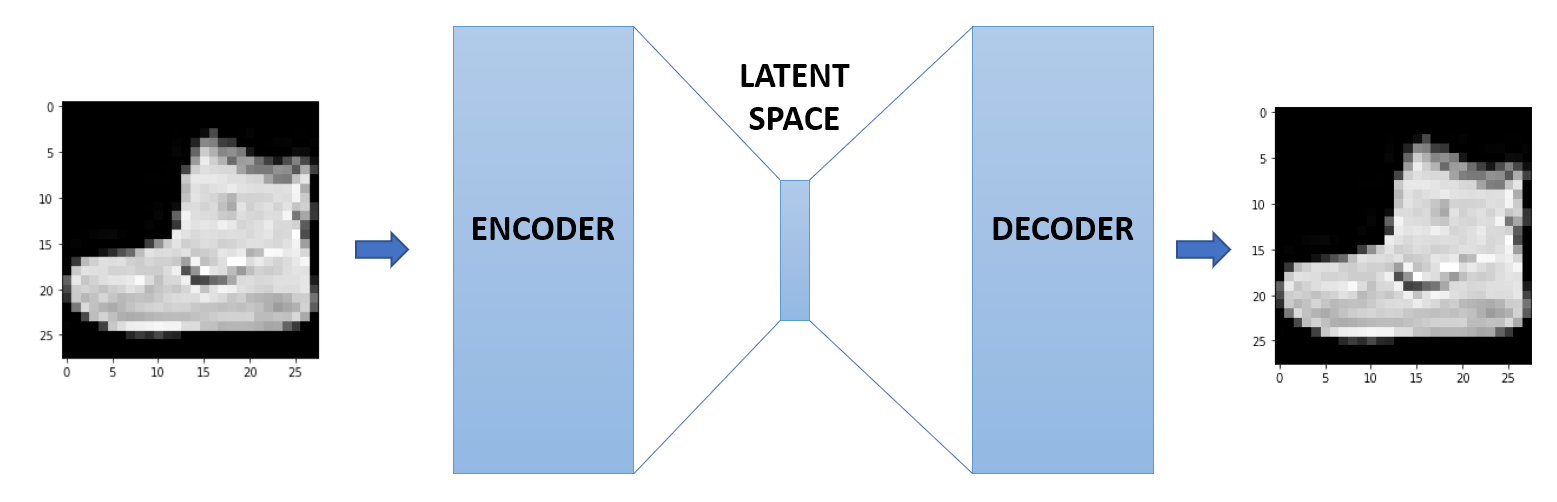



The learning process is described simply as minimizing a loss function $L(x, g(f(x)))$, where $L$ is a loss function penalizing $g(f(x))$ for being dissimilar from $x$, such as the mean squared error.

While the learning is considered to be **unsupervised** since it is using only the value of $x$, the actual implementation is similar to a supervised setting where the label is just derived from the input.
Asides from imput reconstruction, autoencoders have several applications, among which images denoising, filling holes and image generation.

We train and test our architectures on the well-known Fashion-MNIST image dataset. 
Since images are used as training samples, both the encoder and the decoder includes convolutional layers, stacked with linear ones. 

We test both traditional and variational autoencoders for the input reconstruction task. 
Moreover, a supervised fine-tuning approach it is performed, interfacing the encoder with linear classification layers.

We explore the latent space and drawn new samples from it, exploiting Kernel Density Estimation. 

All the experiments and tests performed are implemented with the PyTorch package in Python.

### Dataset <a class="anchor" id="Dataset"></a>

Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of $60000$ samples and a test set of $10000$ samples. Each sample is a 28x28 grayscale image, associated with a label from 10 classes, encoding in an integer number the clothing item type: 
$$\begin{aligned}
\begin{array}{ |c|c| } 
 \hline
 Label & Description  \\ 
 \hline
 0 & T-shirt/top \\ 
 \hline
 1 & Trousers  \\
 \hline
 2 & Pullover  \\
 \hline
 3 & Dress \\
 \hline
 4 & Coat  \\
 \hline
 5 & Sandal  \\
 \hline
 6 & Shirt  \\
 \hline
 7 & Sneaker  \\
 \hline
 8 & Bag  \\
 \hline
 9 & Ankle boot  \\
 \hline
\end{array}
\end{aligned}$$

What is important to be noticed is that, in training and testing the AutoEncoder, labels are ignored: this choice of following an unsupervised approach is done to be consistent with usual applications of autoencoder architectures.

The labels are used just for the visualization of the dataset and for the fine tuning supervised task later on.

At first, the dataset is downloaded and imported. 
Below, some of its items are displayed.




In [2]:
data_dir = 'classifier_data'

train_dataset = torchvision.datasets.FashionMNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.FashionMNIST(data_dir, train=False, download=True)



train_transform = transforms.Compose([
    transforms.ToTensor(),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
])


train_dataset.transform = train_transform
test_dataset.transform = test_transform



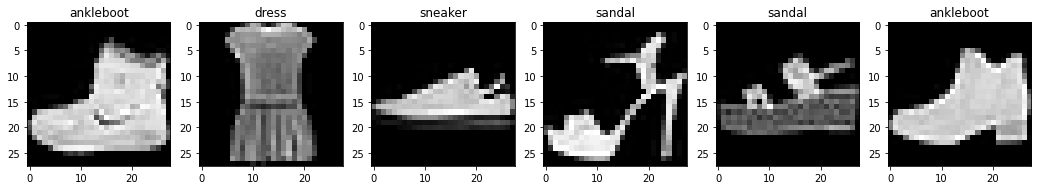

In [3]:
labels = {
            0 : 't-shirt/top',
            1 : 'trousers', 
            2 : 'pullover',
            3 : 'dress', 
            4 : 'coat', 
            5 : 'sandal', 
            6 : 'shirt', 
            7 : 'sneaker', 
            8 : 'bag', 
            9 : 'ankleboot'
         }


n_items = 6
fig, axs = plt.subplots(1, n_items, figsize=(n_items*3, 3))


for i in range(n_items):

    axs[i].imshow(train_dataset.data[i*3], cmap='gray')
    axs[i].set_title(labels[train_dataset.targets[i*3].item()])

## AutoEncoder <a class="anchor" id="AutoEncoder"></a>
At first, we tackle the input reconstruction task exploiting a convolutional autoencoder. 

The framework used is the Lightning package that allows to keep the code minimal and pretty clear.

### Methods <a class="anchor" id="Methods"></a>
The implemented architecture has the following structure:

$$\begin{aligned}
\begin{array}{ |c| }
     \hline  
     \textbf{Encoder} \\
     \hline
     Conv2D( 8, \quad 3\times 3, \quad 2 )  \\
     \hline
      Conv2D(16, \quad 3\times 3, \quad 2)  \\
     \hline
     Conv2D(32, \quad 3\times 3, \quad 2)  \\
     \hline
      Linear(32\times3\times 3, \quad 64)  \\
     \hline
      Linear(64, \quad \text{latent dimension})  \\
     \hline
     \textbf{Decoder} \\
     \hline 
     Linear(\text{latent dimension}, \quad 64)  \\
     \hline
    Linear(64, \quad 32\times3\times 3)  \\
     \hline
     ConvT2D(32, \quad 3\times 3, \quad 2)     \\
     \hline
     ConvT2D(16, \quad 3\times 3, \quad 2)  \\
     \hline
     ConvT2D(8, \quad 3\times 3, \quad 2)     \\
     \hline
\end{array}
\end{aligned}$$

The syntax is the following: 
* Conv2D ( output filters, kernel size, stride ) for convolutional layers,
* Linear ( input nodes, output nodes ) for linear layers,
* ConvT2D ( output filters, kernel size, stride ) for transposed convolutional layers.



The network is trained for 100 epochs applying stochastic gradient descent on Mean Squared Error (MSE) Loss on batches of size 300. The chosen optimizer is Adam with learning rate set to $lr=5\cdot10^{-4}$. 
Both $l_1$ and $l_2$ regulation are applied with penalty, respectively, $10^{-7}$ and $10^{-5}$. 
As a first trial, the dimension of the latent space is set to 2.


In [4]:
class Net(pl.LightningModule):


    def __init__(self, encoded_space_dim, lr, l1, l2):
        super().__init__()
        
        
        self.save_hyperparameters()



        
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, 
                      stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, 
                      stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, 
                      stride=2, padding=0),
            nn.ReLU(True)
        )
        
        self.flatten = nn.Flatten(start_dim=1)

        self.encoder_lin = nn.Sequential(
            nn.Linear(in_features=32*3*3, out_features=64),
            nn.ReLU(True),
            nn.Linear(in_features=64, out_features=encoded_space_dim)
        )
        
        
        self.decoder_lin = nn.Sequential(
            nn.Linear(in_features=encoded_space_dim, out_features=64),
            nn.ReLU(True),
            nn.Linear(in_features=64, out_features=32*3*3),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, 
                               stride=2, output_padding=0),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=3, 
                               stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=8, out_channels=1, kernel_size=3, 
                               stride=2, padding=1, output_padding=1)
        )
        
        
        
        self.encoder = nn.Sequential(self.encoder_cnn, self.flatten, self.encoder_lin)
        self.decoder = nn.Sequential(self.decoder_lin, self.unflatten, self.decoder_conv)
        self.net = nn.Sequential(self.encoder, self.decoder)


        
        
    def forward(self, x, additional_out=False):
       
        x = self.net(x)
        x = torch.sigmoid(x)


        return x
    
    
    
    def training_step(self, batch, batch_idx=None):
        image_batch = batch[0]
        
        x = self.net(image_batch)
        out = torch.sigmoid(x)
        
        loss = F.mse_loss(out, image_batch)
        l1_reg = sum(p.abs().sum() for p in self.net.parameters())
        loss = loss + l1 * l1_reg
        
        self.log('train_loss', loss)


        return loss
    
  

    def validation_step(self, batch, batch_idx=None, loss_name = 'val_loss'):
        image_batch = batch[0]
        out = self.net(image_batch)
        out = torch.sigmoid(out)
        
        loss = F.mse_loss(out, image_batch)
        l1_reg = sum(p.abs().sum() for p in self.net.parameters())
        loss = loss + l1 * l1_reg
        
        self.log(loss_name, loss)
  
        return loss

    def test_step(self, batch, batch_idx):
        self.validation_step(batch, batch_idx, loss_name='test_loss')
      

    def configure_optimizers(self):
        optimizer =  torch.optim.Adam(self.net.parameters(), lr=lr, weight_decay=l2)
        return optimizer
    


In [5]:
class MetricsCallback(Callback):
    """PyTorch Lightning metric callback."""

    def __init__(self):
        super().__init__()
        self.metrics = []

    def on_validation_epoch_end(self, trainer, pl_module):
        self.metrics.append({key: val.item() for (key, val) in trainer.callback_metrics.items()})
        

In [6]:
def save_model(name : str, trainer : 'pl.Trainer', metrics : 'MetricsCallback'):
    trainer.save_checkpoint(model_folder + name + '.ckpt')
    df = pd.DataFrame(metrics_callback.metrics)
    df.to_csv(model_folder + name + '.csv', index=False)
    
    
def load_model(name : str, module : 'pl.Module'):
    model = module.load_from_checkpoint(model_folder + name + '.ckpt')
    metrics = pd.read_csv(model_folder + name + '.csv')
    return model, metrics

In [7]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
num_workers=8

In [8]:
lr = 5e-4 
l2 = 1e-5
l1 = 1e-7
encoded_space_dim = 2 
batch_size =  300



train_dataloader = DataLoader(train_dataset, 
                              batch_size=batch_size, 
                              shuffle=True, 
                              num_workers=num_workers)
test_dataloader  = DataLoader(test_dataset,  
                              batch_size=len(test_dataset), 
                              shuffle=False, 
                              num_workers=num_workers)



metrics_callback = MetricsCallback()
checkpoint_callback = ModelCheckpoint(dirpath='checkpoints', monitor="val_loss")



trainer = pl.Trainer(gpus=1 if torch.cuda.is_available() else None,
                     max_epochs=100,
                     callbacks=[metrics_callback, 
                               checkpoint_callback],
                     enable_progress_bar=False,
                     enable_model_summary=True, 
                     val_check_interval=1.0)



litnet = Net(encoded_space_dim, lr, l1, l2)
trainer.fit(litnet, train_dataloader, test_dataloader)


/Users/giulia/opt/anaconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /Users/giulia/Desktop/NNeDL/Homework/2/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


In [9]:
trainer.test(litnet, test_dataloader)


model_folder = 'checkpoints/'
save_model('trial', trainer, metrics_callback)
litnet, metrics = load_model('trial', Net)

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.027272801846265793}
--------------------------------------------------------------------------------


### Results <a class="anchor" id="Results"></a>


At first, above is reported the MSE loss obtained on the test set, returning a metrics value of $MSE_{test}=2.7\cdot10^{-2}$.

In order to monitor the learning process, the loss curve is displayed.
No discrepancy is highlighted between the training and validation graphs and boths display good convergence behaviours, so that overfitting issues is excluded.


##### Loss curve

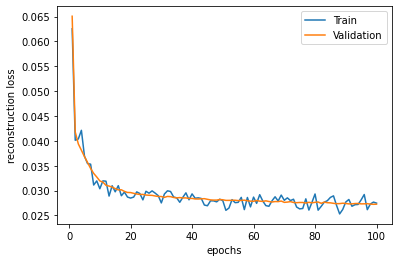

In [10]:
xs = np.arange(len(metrics) - 1) + 1

plt.plot(xs, metrics['train_loss'][1:], label='Train')
plt.plot(xs, metrics['val_loss'][1:], label='Validation')
plt.xlabel('epochs')
plt.ylabel('reconstruction loss')
plt.legend()
plt.show()

#### Predictions
##### Reconstructed images
To test the predictive capability of the network, the comparison between some input images and their network reconstructions is displayed below. 
We can see that the reconstructed image has, despite missing some details, enough resolution to assign each reconstructed object to the proper category.

[W NNPACK.cpp:79] Could not initialize NNPACK! Reason: Unsupported hardware.


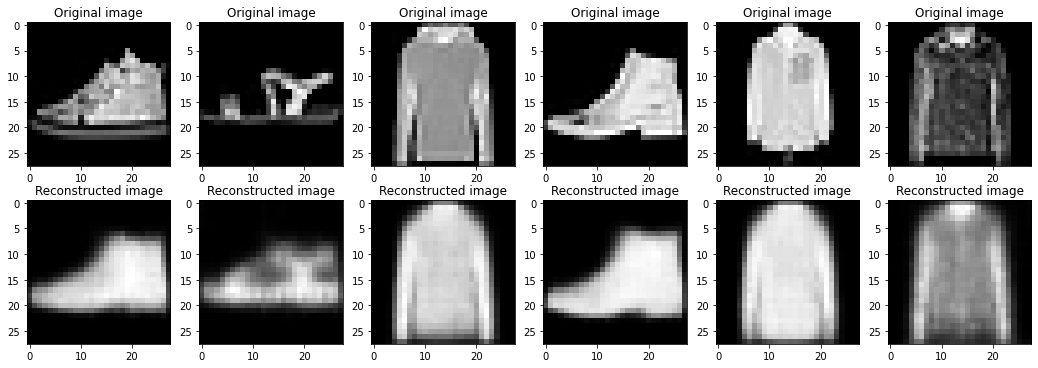

In [11]:
n_images = 6

fig, axs = plt.subplots(2, n_images, figsize=(18, 6))
plotted_samples = []

for i in range(n_images):
    j = np.random.randint(len(test_dataset))
    plotted_samples.append(j)
    img = test_dataset[j][0].unsqueeze(0).to(device)
    with torch.no_grad():
        rec_img  = litnet.net(img)
        rec_img =  torch.sigmoid(rec_img)

    axs[0, i].imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
    axs[0, i].set_title('Original image')
    axs[1, i].imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
    axs[1, i].set_title('Reconstructed image')

### Samples generation <a class="anchor" id="Generation"></a>

#### Latent space inspection

Here, we inspect the 2D latent space structure by displaying the distribution of encoded images.
Then, we apply Kernel Density Estimation (KDE) to this compressed dataset and we exploit it to sample new instances in the latent space, that are decompressed into clothing images by the decoder.
The tuning of KDE bandwith is done via grid-searching. 

In order, the following results are displayed:

* 2D histogram reporting the distribution of encoded test samples in the latent space, 
* comparison between the test dataset distribution and KDE sampled data distribution,
* example images obtained decoding the KDE generated samples

From this last one, we see that all the newly generated samples, when decoded, are easily traceable to a well-defined clothing category.

In [12]:
encoded_samples = []
for sample in test_dataset:
    img = sample[0].unsqueeze(0).to(device)
    encoded_img  = litnet.encoder(img)
    encoded_img = encoded_img.flatten().cpu().detach().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_samples.append(encoded_sample)
    
encoded_samples = pd.DataFrame(encoded_samples)

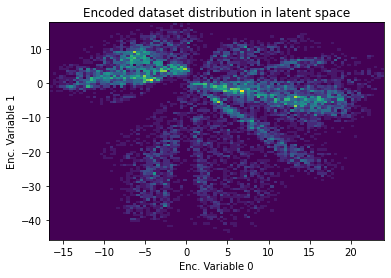

In [13]:
plt.hist2d(encoded_samples['Enc. Variable 0'], 
                         encoded_samples['Enc. Variable 1'], 
                         bins=(100, 100),
                         density=True)
plt.xlabel('Enc. Variable 0')
plt.ylabel('Enc. Variable 1')
plt.title('Encoded dataset distribution in latent space')

plt.show()

#### Kernel Density Estimation Sampling

In [14]:
from sklearn.neighbors import KernelDensity
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV


params = {"bandwidth": np.logspace(-1, 1, 20)}
grid = GridSearchCV(KernelDensity(), params)
grid.fit(encoded_samples.to_numpy())

print("best bandwidth: {0}".format(grid.best_estimator_.bandwidth))


kde = grid.best_estimator_

new_data = kde.sample(10000, random_state=0)

best bandwidth: 0.6951927961775606


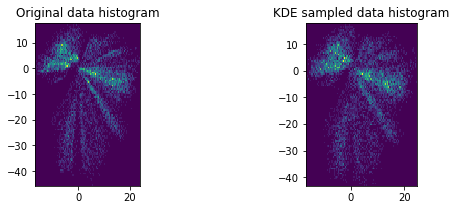

In [15]:
new_data = pd.DataFrame(new_data, 
                        columns=[f"Enc. Variable {i}" for i in range(encoded_space_dim)])

fig, axs = plt.subplots(1, 2, figsize=(9, 3))

axs[0].hist2d(encoded_samples['Enc. Variable 0'], 
                         encoded_samples['Enc. Variable 1'], 
                         bins=(100, 100), 
                         density=True
                )
axs[0].set_title('Original data histogram')
axs[1].hist2d(new_data['Enc. Variable 0'], new_data['Enc. Variable 1'],
              bins=(100, 100))
axs[1].set_title('KDE sampled data histogram')
for ax in axs:    
    ax.set(aspect='equal')


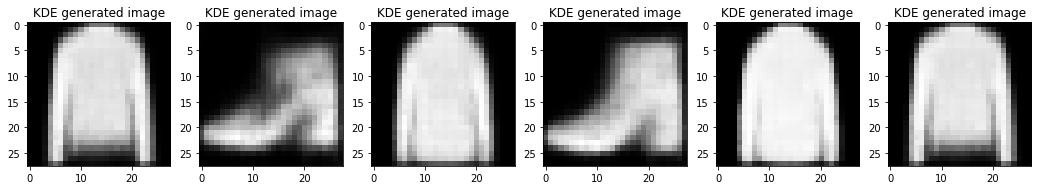

In [16]:
n_images = 6

fig, axs = plt.subplots(1, n_images, figsize=(18, 3))


if encoded_space_dim == 2:
    for n in range(n_images):
    
        i = np.random.randint(len(new_data))
        custom_encoded_sample = [new_data.iloc[i,j] for j in range(encoded_space_dim)]
        encoded_value = torch.tensor(custom_encoded_sample).float().unsqueeze(0).to(device)

        with torch.no_grad():
            generated_img  = litnet.decoder(encoded_value)
            generated_img = torch.sigmoid(generated_img)

        axs[n].imshow(generated_img.squeeze().cpu().numpy(), cmap='gist_gray')
        axs[n].set_title('KDE generated image')

## Optuna optimization <a class="anchor" id="Optuna"></a>

After the implementation and testing of the first architecture, the optimization of its hyper-parameters is performed via the Optuna package.
The boosted parameters are the latent space dimension, the learning rate, $l_1$ and $l_2$ penalties.
After returning the best configuration out of 15 trials, the correspondent network is trained for 100 epochs via stochastic gradient descent on batches of size 300 using the Adam optimizer.
The best configuration turns out to be: 
* latent space dimension: 8
* $lr: 2.5\cdot 10^{-4}$
* $l_1: 3.3\cdot 10^{-4}$
* $l_2: 3.9\cdot 10^{-6}$

In [17]:
def objective(trial):

    params = [
        trial.suggest_int("encoded_space_dim", 2, 12, log=True), 
        trial.suggest_float('lr', 1e-5, 1e-2, log=True), 
        trial.suggest_float('l1', 1e-6, 1e-3, log=True),
        trial.suggest_float('l2', 1e-6, 1e-3, log=True)
    ]

    model = Net(*params)

    trainer = pl.Trainer(accelerator="cpu",
                         max_epochs=10, 
                         val_check_interval=1.0, 
                         log_every_n_steps=1, 
                         enable_progress_bar=False,
                         enable_model_summary=False )
    hyperparameters = dict(params=params)
    trainer.logger.log_hyperparams(hyperparameters)
    trainer.fit(model, train_dataloader, test_dataloader)

    return trainer.callback_metrics["val_loss"].item()

pruner: optuna.pruners.BasePruner = optuna.pruners.NopPruner()

study = optuna.create_study(study_name="netoptimization", direction="minimize", pruner=pruner)
study.optimize(objective, n_trials=15)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials: 15
Best trial:
  Value: 0.020679106935858727
  Params: 
    encoded_space_dim: 8
    lr: 0.0002494225473870696
    l1: 3.3229929142012776e-05
    l2: 3.896616282569124e-06


In [29]:
best_net = Net(**study.best_params)


metrics_callback = MetricsCallback()
checkpoint_callback = ModelCheckpoint(dirpath='checkpoints', monitor="val_loss")

trainer = pl.Trainer(gpus=1 if torch.cuda.is_available() else None,
                     max_epochs=100,
                     callbacks=[metrics_callback, 
                               checkpoint_callback],
                     enable_progress_bar=True, 
                     val_check_interval=1.0)


trainer.fit(best_net, train_dataloader, test_dataloader)



Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [31]:
trainer.test(best_net, test_dataloader)


model_folder = 'checkpoints/'
save_model('best_ae', trainer, metrics_callback)
litnet, metrics = load_model('best_ae', Net)

Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.015242916531860828}
--------------------------------------------------------------------------------


### Results <a class="anchor" id="Optuna-Results"></a>

As reported, MSE loss evaluated on the test set returns a value of $MSE_{test}=1.5\cdot10^{-2}$, showing a better performance when optimizing hyperparameters via optuna.

#### Reconstructed Images
We report here the images reconstructed by this best-tuned network. 
We can see that reconstructed images quality is way better than the plain architecture ones.

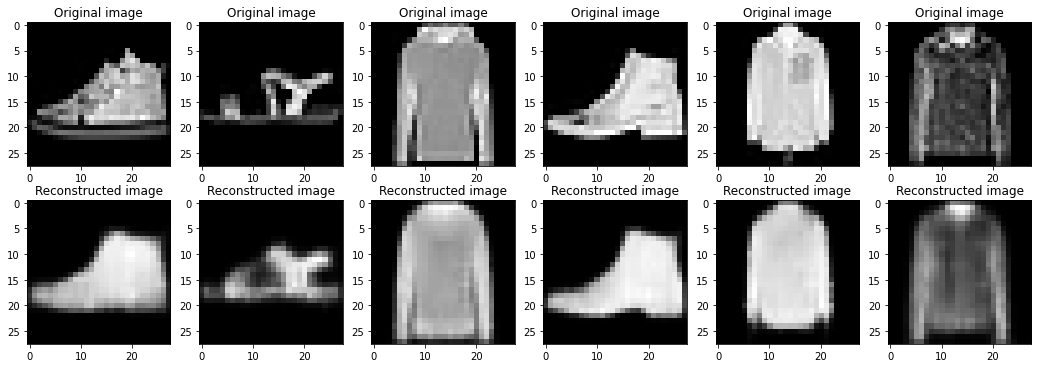

In [32]:
n_images = 6

fig, axs = plt.subplots(2, n_images, figsize=(18, 6))

for i in range(n_images):
    j = plotted_samples[i]
    img = test_dataset[j][0].unsqueeze(0).to(device)
    with torch.no_grad():
        rec_img  = best_net.net(img)
        rec_img = torch.sigmoid(rec_img)

    axs[0, i].imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
    axs[0, i].set_title('Original image')
    axs[1, i].imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
    axs[1, i].set_title('Reconstructed image')

### PCA and t-SNE & Samples generation <a class="anchor" id="Optuna-Generation"></a>
#### PCA and t-SNE: data visualization

Now, since, as it could be expected, the latent space dimension is bigger than before, dimensionality reduction techniques are needed to inspect its structure. 
In particular, PCA and t-SNE with reduction to 2 components are exploited. 
The results of their application for 2D plotting are reported below.

/Users/giulia/opt/anaconda3/envs/torch/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/giulia/opt/anaconda3/envs/torch/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


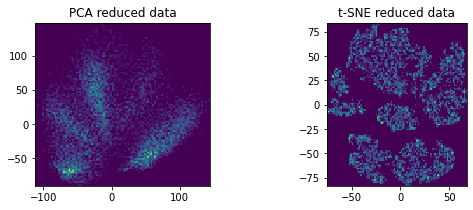

In [33]:
encoded_samples = []
for sample in test_dataset:
    img = sample[0].unsqueeze(0).to(device)
    encoded_img  = best_net.encoder(img)
    encoded_img = encoded_img.flatten().cpu().detach().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_samples.append(encoded_sample)

encoded_samples = pd.DataFrame(encoded_samples)


n_components = 2
pca = PCA(n_components=n_components)
encoded_samples_reduced_PCA = pca.fit_transform(encoded_samples)
tsne = TSNE(n_components=n_components)
encoded_samples_reduced_TSNE = tsne.fit_transform(encoded_samples)


fig, axs = plt.subplots(1, 2, figsize=(9, 3))

axs[0].hist2d(encoded_samples_reduced_PCA[:,0], encoded_samples_reduced_PCA[:,1],
              bins=(100, 100),
             density=True)
axs[0].set_title('PCA reduced data')
axs[1].hist2d(encoded_samples_reduced_TSNE[:,0], encoded_samples_reduced_TSNE[:,1], 
             bins=(100,100), 
             density=True)
axs[1].set_title('t-SNE reduced data')


for ax in axs:    
    ax.set(aspect='equal')
    #ax.set_axis_off()



We can see how, thanks to the non-linear nature of T-SNE, it is able to stretch the latent space and organize categorical data into clusters.

####  KDE sampling in PCA reducted space
Again, we make use of KDE for generating new data following the test encoded samples distribution in latent space. However, this time we do not sample directly the encoded samples, but their PCA reducted equivalent.
This choice is done since KDE performs poorly in high dimensions ($d>3$).
So, we compare PCA reducted test samples and this KDE generated data. 
Then, we perform the inverse transform w.r.t PCA so that we get samples that can feed the decoder, from which new clothes images are generated. They are reported in the last plot, in which we can see that, despite all the compression and decompression phases the data have undergone, still they produce items easily traceable to a well-defined clothing category.

In [34]:
params = {"bandwidth": np.logspace(-1, 1, 20)}
grid = GridSearchCV(KernelDensity(), params)
grid.fit(encoded_samples_reduced_PCA)

print("best bandwidth: {0}".format(grid.best_estimator_.bandwidth))

kde = grid.best_estimator_

new_data_pca = kde.sample(10000, random_state=0)
new_data = pca.inverse_transform(new_data_pca)

best bandwidth: 3.79269019073225


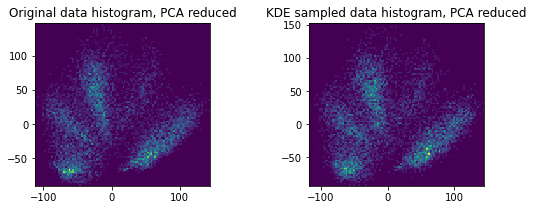

In [35]:
encoded_samples_reduced_PCA = pd.DataFrame(encoded_samples_reduced_PCA, 
                        columns=[f"Enc. Variable {i}" for i in range(n_components)])

new_data_pca = pd.DataFrame(new_data_pca, 
                        columns=[f"Enc. Variable {i}" for i in range(n_components)])

fig, axs = plt.subplots(1, 2, figsize=(9, 3))

axs[0].hist2d(encoded_samples_reduced_PCA['Enc. Variable 0'], 
              encoded_samples_reduced_PCA['Enc. Variable 1'], 
                         bins=(100, 100))
axs[0].set_title('Original data histogram, PCA reduced')

axs[1].hist2d(new_data_pca['Enc. Variable 0'], 
              new_data_pca['Enc. Variable 1'],
              bins=(100, 100))
axs[1].set_title('KDE sampled data histogram, PCA reduced')

for ax in axs:    
    ax.set(aspect='equal')
    #ax.set_axis_off()

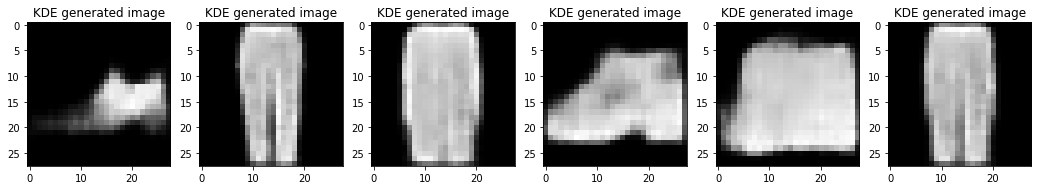

In [36]:
n_images = 6

fig, axs = plt.subplots(1, n_images, figsize=(18, 3))

for n in range(n_images):
    i = np.random.randint(len(new_data))
    custom_encoded_sample = [new_data[i, j] for j in range(study.best_params['encoded_space_dim'])]

    encoded_value = torch.tensor(custom_encoded_sample).float().unsqueeze(0).to(device)

    with torch.no_grad():
        generated_img  = best_net.decoder(encoded_value)
        generated_img = torch.sigmoid(generated_img)

    axs[n].imshow(generated_img.squeeze().cpu().numpy(), cmap='gist_gray')
    axs[n].set_title('KDE generated image')





## Supervised fine-tuning <a class="anchor" id="Supervised"></a>
Now we aim at expoiting the pre-trained encoder from the full autoencoder architecture and to interface it with linear layers, in order to perform classification via supervised learning.
The encoder has already been fine-tuned by previous training and its weights are then kept fixed. Gradient descent is applied only to the linear stack.

### Methods <a class="anchor" id="Supervised-Methods"></a>
In particular, we interace the encoder with a stack of two linear layers:
* Linear(encoded_dim, linear_dim),
* Linear(linear_dim, 10).

The optimal output size for the hidden layer _linear_dim_ is set via Optuna Optimization, that retrieve a value of 126. 
After this tuning phase, the network is trained for 100 epochs applying stochastic gradient descent on Cross Entropy Loss on batches of size 300. The chosen optimizer is Adam. The learning rate $lr=$, $l_1$ and $l_2$ penalties and the dimension of the latent space are set to the optimal values found before.


In [37]:
class FineTuningNet(pl.LightningModule):


    def __init__(self, pretrained_encoder, lin_dim, encoded_space_dim, lr, l1, l2):
        super().__init__()
        
        
        self.save_hyperparameters()


        self.pretrained = pretrained_encoder
        
        
    
        
        self.lin = nn.Sequential(
            nn.Linear(in_features=encoded_space_dim, out_features=lin_dim),
            nn.ReLU(True),
            nn.Linear(in_features=lin_dim, out_features=10),
            nn.LogSoftmax(dim=1)
        )

        self.net = nn.Sequential(self.pretrained, self.lin)
        

        
        
    def forward(self, x, additional_out=False):
        x = self.net(x)


        return x
    
    
    
    def training_step(self, batch, batch_idx=None):
        image_batch = batch[0]
        label_batch = batch[1]
        
        out = self.net(image_batch)
        
        loss = F.cross_entropy(out, label_batch)
        l1_reg = sum(p.abs().sum() for p in self.net.parameters())
        loss = loss + l1 * l1_reg
        
        
        
        self.log('train_loss', loss)
        
        
        _, predicted = torch.max(out, 1)


        accuracy = (predicted==label_batch).sum()/len(label_batch)
        self.log('train_accuray', accuracy)


        return loss
    
  

    def validation_step(self, batch, batch_idx=None):
        
        image_batch = batch[0]
        label_batch = batch[1]
        
        out = self.net(image_batch)
        
        loss = F.cross_entropy(out, label_batch)
        l1_reg = sum(p.abs().sum() for p in self.net.parameters())
        loss = loss + l1 * l1_reg
        
        self.log('val_loss', loss)
        
        _, predicted = torch.max(out, 1)
        accuracy = (predicted==label_batch).sum()/len(label_batch)
        self.log('val_accuray', accuracy)
        
        return loss
      

    def configure_optimizers(self):
        
        optimizer =  torch.optim.Adam(filter(lambda p: p.requires_grad, self.net.parameters()), lr=lr, weight_decay=l2)
        return optimizer
    



In [38]:
def objective(trial):

    params = [
        trial.suggest_int("lin_dim", 16, 128)
    ]

    model = FineTuningNet(best_net.encoder, *params, **study.best_params)

    trainer = pl.Trainer(accelerator="cpu",
                         max_epochs=10, 
                         val_check_interval=1.0, 
                         log_every_n_steps=1, 
                         enable_progress_bar=False,
                         enable_model_summary=False )
    
    hyperparameters = dict(params=params)
    trainer.logger.log_hyperparams(hyperparameters)
    
    for param in model.pretrained.parameters():
        param.requires_grad = False    
    
    
    trainer.fit(model, train_dataloader, test_dataloader)

    return trainer.callback_metrics["val_loss"].item()

pruner: optuna.pruners.BasePruner = optuna.pruners.NopPruner()

study_ft = optuna.create_study(study_name="netoptimization", direction="minimize", pruner=pruner)
study_ft.optimize(objective, n_trials=10)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study_ft.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials: 15
Best trial:
  Value: 0.5096938014030457
  Params: 
    lin_dim: 126


In [39]:
encoder = best_net.encoder
ftnet = FineTuningNet(encoder, **study_ft.best_params, **study.best_params)

metrics_callback = MetricsCallback()
checkpoint_callback = ModelCheckpoint(dirpath='checkpoints', monitor="val_loss")

trainer = pl.Trainer(gpus=1 if torch.cuda.is_available() else None,
                     max_epochs=100,
                     callbacks=[metrics_callback, 
                               checkpoint_callback],
                     enable_progress_bar=True, 
                     val_check_interval=1.0)



for param in ftnet.pretrained.parameters():
    param.requires_grad = False        
        

trainer.fit(ftnet, train_dataloader, test_dataloader)


/Users/giulia/opt/anaconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /Users/giulia/Desktop/NNeDL/Homework/2/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [40]:
model_folder = 'checkpoints/'
save_model('fine_tuning', trainer, metrics_callback)


In [41]:
ftnet, metrics = load_model('fine_tuning', FineTuningNet)

### Results <a class="anchor" id="Supervised-Results"></a>
#### Loss curve
In order the keep track of the learning process, we report here the loss-accuracy curve over training epochs.
We see that, due to stochastic gradient descent on batches, both loss and accuracy in the training steps are pretty noisy. However, the validation metrics show good convergence.

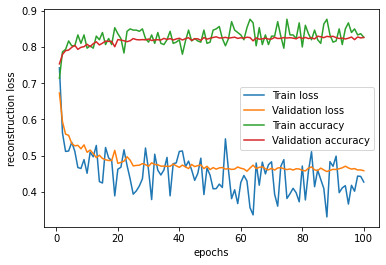

In [42]:
xs = np.arange(len(metrics) - 1) + 1

plt.plot(xs, metrics['train_loss'][1:], label='Train loss')
plt.plot(xs, metrics['val_loss'][1:], label='Validation loss')
plt.plot(xs, metrics['train_accuray'][1:], label='Train accuracy')
plt.plot(xs, metrics['val_accuray'][1:], label='Validation accuracy')
plt.xlabel('epochs')
plt.ylabel('reconstruction loss')
plt.legend()
plt.show()

#### Test accuracy
Here, the normalized confusion matrix is reported, in order to compute test accuracy per each category. We see that the lowest accuracy is retrieved in the 'Shirt' category, that is easily misclassified as 'T-shirt', 'Pullover' and 'Coat'. On the other hand, the model gets top scoring in the 'Bag' cluster, since no similar categories are present.

The total test accuracy is $83\%$.

This is quite close to the $89\%$ value reached in Homework 1. What is noticeable is that in this case the number of trainable parameters is about $\frac{1}{10}$ of the one needed in the previous homework. Clearly, this complexity discrepancy is reflected in the training time. 

Test accuracy: 0.83


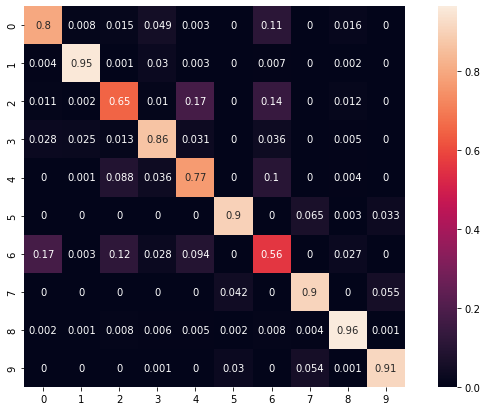

In [43]:
dataiter = iter(test_dataloader)
images, labels = dataiter.next()



predicted = ftnet.net(images)

_, pred_y = torch.max(predicted, 1)
test_y = test_dataset.targets.type(torch.int64).reshape(10000)


print(f'Test accuracy: {(sum(pred_y==test_y).item()/len(test_y)):.2f}' )


cf_matrix = confusion_matrix(test_y, pred_y, normalize='true')
df_cm = pd.DataFrame(cf_matrix , index = [i for i in range(10)],
                     columns = [i for i in range(10)])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)   
plt.imshow(cf_matrix)
plt.show()



## Variational AutoEncoder <a class="anchor" id="VAE"></a>


In standard autoencoders, the latent space can be extremely irregular making generative process in the latent space often returning meaningless samples.
In variational autoencoders, then, the encoder returns a distribution $q(z|x)$ over the latent space instead of a single point
and the loss function has an additional regularisation term.
The encoded distribution is chosen to be a multivariate Gaussian, so that the encoder can be trained to estimate the mean and covariance matrix. So, within this framework, the latent representation is now defined by two vectors containg the mean and variance of this high-dimension Gaussian distribution.
The decoder is then fed with a sample $z\sim q(z|x)$.

The covariance could just be a square matrix; however, to reduce computational complexity it is assumed that the multivariate Gaussian has a diagonal covariance matrix.
This way we can regularize the loss function by forcing the latent distribution to be as close as possible to a standard Normal distribution.


The loss function is given by the minimization of both the Kullback-Leiber divergence between the encoded distribution $q(z|x)$ and the target distribution $p(z)$ (that in our case we recall it is a standard Normal distribution $\mathcal{N}(0, 1)$) and the reconstruction loss $p(x|z)$. It is called the ELBO:
$$\mathcal{L}=\mathbb{E}_q[\log q(z|x)-\log p(z)-\log p(x|z)]$$



### Methods <a class="anchor" id="VAE-Methods"></a>

The implemented architecture is pretty similar to the one used as plain autoencoder:

$$\begin{aligned}
\begin{array}{ |c| }
     \hline  
     \textbf{Encoder} \\
     \hline
     Conv2D( 8, \quad 3\times 3, \quad 2 )  \\
     \hline
      Conv2D(16, \quad 3\times 3, \quad 2)  \\
     \hline
     Conv2D(32, \quad 3\times 3, \quad 2)  \\
     \hline
      Linear(32\times3\times 3, \quad 64)  \\
     \hline
      Linear(64, \quad \text{encoder out dimension})  \\
     \hline
     \textbf{Sampling} \\
     \hline
     \textbf{Decoder} \\
     \hline 
     Linear(\text{latent dimension}, \quad 64)  \\
     \hline
    Linear(64, \quad 32\times3\times 3)  \\
     \hline
     ConvT2D(32, \quad 3\times 3, \quad 2)     \\
     \hline
     ConvT2D(16, \quad 3\times 3, \quad 2)  \\
     \hline
     ConvT2D(8, \quad 3\times 3, \quad 2)     \\
     \hline
\end{array}
\end{aligned}$$




The _Sampling_ phase include two linear layers:
* $\mu$: Linear(encoder out dimension, latent dimension) 
* Cov: Linear(encoder out dimension, latent dimension) 

The network is trained for 100 epochs applying stochastic gradient descent on Cross Entropy Loss on batches of size 300. The chosen optimizer is Adam. The learning rate $lr=$, $l_1$ and $l_2$ penalties and the dimension of the latent space are set to the optimal values found before via Optuna optimization.



In [44]:
class VAE(pl.LightningModule):
    

    def __init__(self, enc_out_dim, latent_dim, lr, l1, l2):
        super().__init__()
        
        
        self.save_hyperparameters()


        
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, 
                      stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, 
                      stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, 
                      stride=2, padding=0),
            nn.ReLU(True)
        )
        
        self.flatten = nn.Flatten(start_dim=1)

        self.encoder_lin = nn.Sequential(
            nn.Linear(in_features=32*3*3, out_features=64),
            nn.ReLU(True),
            nn.Linear(in_features=64, out_features=enc_out_dim)
        )
        
        
        self.decoder_lin = nn.Sequential(
            nn.Linear(in_features=latent_dim, out_features=64),
            nn.ReLU(True),
            nn.Linear(in_features=64, out_features=32*3*3),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, 
                               stride=2, output_padding=0),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=3, 
                               stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=8, out_channels=1, kernel_size=3, 
                               stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )
        
        
        
        self.encoder = nn.Sequential(self.encoder_cnn, self.flatten, self.encoder_lin)
        self.decoder = nn.Sequential(self.decoder_lin, self.unflatten, self.decoder_conv)



        self.fc_mu = nn.Linear(enc_out_dim, latent_dim)
        self.fc_var = nn.Linear(enc_out_dim, latent_dim)

        self.log_scale = nn.Parameter(torch.Tensor([0.0]))
        
        

    def configure_optimizers(self):
        optimizer =  torch.optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        return optimizer
        
   

    def gaussian_likelihood(self, x_hat, logscale, x):
        scale = torch.exp(logscale)
        mean = x_hat
        dist = torch.distributions.Normal(mean, scale)

        log_pxz = dist.log_prob(x)
        return log_pxz.sum(dim=(1, 2, 3))

    def kl_divergence(self, z, mu, std):
        # --------------------------
        # Monte carlo KL divergence
        # --------------------------
        # 1. define the first two probabilities (in this case Normal for both)
        p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
        q = torch.distributions.Normal(mu, std)

        # 2. get the probabilities from the equation
        log_qzx = q.log_prob(z)
        log_pz = p.log_prob(z)

        # kl
        kl = (log_qzx - log_pz)
        kl = kl.sum(-1)
        return kl
    
    
    def forward(self, x): 
       
        # encode x to get the mu and variance parameters
        x_encoded = self.encoder(x)
        mu, log_var = self.fc_mu(x_encoded), self.fc_var(x_encoded)

        # sample z from q
        std = torch.exp(log_var / 2)
        q = torch.distributions.Normal(mu, std)
        z = q.rsample()
        
        return z
        

    def training_step(self, batch, batch_idx):
        x, _ = batch

        # encode x to get the mu and variance parameters
        x_encoded = self.encoder(x)
        mu, log_var = self.fc_mu(x_encoded), self.fc_var(x_encoded)

        # sample z from q
        std = torch.exp(log_var / 2)
        q = torch.distributions.Normal(mu, std)
        z = q.rsample()

        # decoded
        x_hat = self.decoder(z)

        # reconstruction loss
        recon_loss = self.gaussian_likelihood(x_hat, self.log_scale, x)

        # kl
        kl = self.kl_divergence(z, mu, std)

        # elbo
        elbo = (kl - recon_loss)
        l1_reg = sum(p.abs().sum() for p in self.parameters())
        elbo = elbo.mean() - l1 * l1_reg
        

        self.log_dict({
            'elbo': elbo,
            'kl': kl.mean(),
            'recon_loss': recon_loss.mean(),
            'reconstruction': recon_loss.mean(),
            'kl': kl.mean(),
        })

        return elbo
    
    def validation_step(self, batch, batch_idx, loss_name='val'):
        x, _ = batch

        # encode x to get the mu and variance parameters
        x_encoded = self.encoder(x)
        mu, log_var = self.fc_mu(x_encoded), self.fc_var(x_encoded)

        # sample z from q
        std = torch.exp(log_var / 2)
        q = torch.distributions.Normal(mu, std)
        z = q.rsample()

        # decoded
        x_hat = self.decoder(z)

        # reconstruction loss
        recon_loss = self.gaussian_likelihood(x_hat, self.log_scale, x)

        # kl
        kl = self.kl_divergence(z, mu, std)

        # elbo
        elbo = (kl - recon_loss)
        l1_reg = sum(p.abs().sum() for p in self.parameters())
        elbo = elbo.mean() - l1 * l1_reg
        
        
        
        self.log_dict({
            loss_name+'_elbo': elbo,
            loss_name+'_kl': kl.mean(),
            loss_name+'_recon_loss': recon_loss.mean(),
            loss_name+'_reconstruction': recon_loss.mean(),
            loss_name+'_kl': kl.mean(),
        })

        return elbo
    
    def test_step(self, batch, batch_idx, loss_name='test'):
        self.validation_step(batch, batch_idx, loss_name='test_loss')


    


In [69]:

batch_size =  300
train_dataloader = DataLoader(train_dataset, 
                              batch_size=batch_size, 
                              shuffle=True, 
                              num_workers=num_workers)
test_dataloader  = DataLoader(test_dataset,  
                              batch_size=len(test_dataset), 
                              shuffle=False, 
                              num_workers=num_workers)



metrics_callback = MetricsCallback()
checkpoint_callback = ModelCheckpoint(dirpath='checkpoints', monitor='val_elbo')

trainer = pl.Trainer(gpus=1 if torch.cuda.is_available() else None,
                     max_epochs=100,
                     callbacks=[metrics_callback, 
                               checkpoint_callback],
                     enable_progress_bar=True,
                     enable_model_summary=True, 
                     val_check_interval=1.0)


enc_out_dim = 16
latent_dim, lr, l1, l2 = study.best_params.values()



vae = VAE(enc_out_dim, latent_dim, lr, l1, l2)


trainer.fit(vae, train_dataloader, test_dataloader)


/Users/giulia/opt/anaconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /Users/giulia/Desktop/NNeDL/Homework/2/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [70]:
trainer.test(vae, test_dataloader)
model_folder = 'checkpoints/'
save_model('vae', trainer,  metrics_callback)
vae, metrics = load_model('vae', VAE)

Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss_elbo': -459.3363952636719,
 'test_loss_kl': 19.981359481811523,
 'test_loss_recon_loss': 478.033447265625,
 'test_loss_reconstruction': 478.033447265625}
--------------------------------------------------------------------------------


### Results <a class="anchor" id="VAE-Results"></a>
#### Reconstruction loss

In order to monitor the learning process, the loss curve is displayed.
No discrepancy is highlighted between the training and validation graphs and boths display good convergence behaviours, so that overfitting issues is excluded.

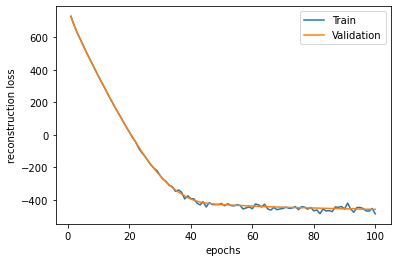

In [71]:
xs = np.arange(len(metrics) - 1) + 1

plt.plot(xs, metrics['elbo'][1:], label='Train')
plt.plot(xs, metrics['val_elbo'][1:], label='Validation')

plt.xlabel('epochs')
plt.ylabel('reconstruction loss')
plt.legend()
plt.show()

#### Reconstructed images


We report here the images reconstructed by the variational auto encoder and we see that they display overall good resolution.

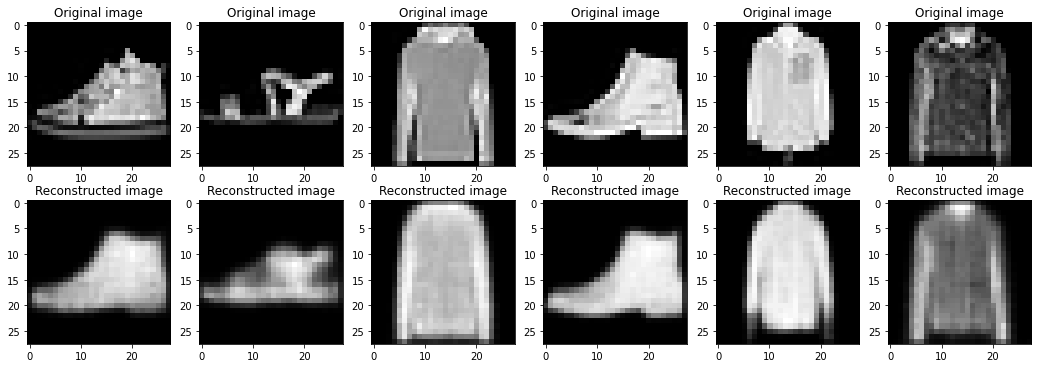

In [72]:
n_images = 6

fig, axs = plt.subplots(2, n_images, figsize=(18, 6))

for i in range(n_images):
    j = plotted_samples[i]
    img = test_dataset[j][0].unsqueeze(0).to(device)
    with torch.no_grad():
        sampled_img = vae.forward(img)
        rec_img  = vae.decoder(sampled_img)

    axs[0, i].imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
    axs[0, i].set_title('Original image')
    axs[1, i].imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
    axs[1, i].set_title('Reconstructed image')

#### Samples generation

Finally, we exploit the generative capability of this variational architecture. The encoded items are obtained by drawing random samples $z\sim \mathcal{N}(0, 1)$. Despite this, the obtained samples are easily traceable to a well-defined clothing category, showing the smoothness of the latent space for variational autoencoders.

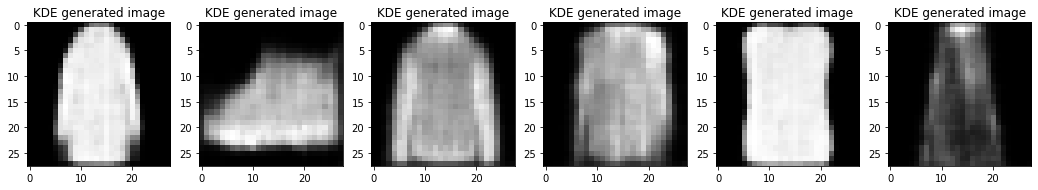

In [75]:
n_images = 6

fig, axs = plt.subplots(1, n_images, figsize=(18, 6))

for n in range(n_images):
    
    
    with torch.no_grad():
        sampled_img = torch.randn((1, latent_dim), device=device)
        rec_img  = vae.decoder(sampled_img)

    axs[n].imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
    axs[n].set_title('KDE generated image')

## Conclusions  <a class="anchor" id="Conclusions"></a>

In this report, three different architectures based on autoencoding have been implemented and tested. 
In particular, plain autoencoders turns out to tackle greatly the image reconstruction task, in particular when finely-tuned via hyper-parameters oprimization.
Variational autoencoder, in addition, grants an higher-quality samples generation phase, when encoded samples are thrown at random. 
Finally, we see how via supervised fine-tuning, encoders can perform pretty well in classification tasks, despite needing much less trainable parameters.